In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot styles
sns.set_style("whitegrid")


In [3]:
# Assuming the raw data (e.g., 'transactions.csv') is in the 'data/raw/' folder
try:
    df = pd.read_csv('../data/data.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure your data file is located in the 'data' directory.")

Data loaded successfully.


In [4]:
# Display first few rows
print("--- Head of Data ---")
print(df.head())

# Display dataset shape (rows, columns)
print("\n--- Data Shape ---")
print(df.shape)

# Get column names, non-null counts, and data types
print("\n--- Data Info (Types and Nulls) ---")
print(df.info())

--- Head of Data ---
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Va

In [5]:
# Use 'Value' and 'Amount' (the key numerical transaction features)
print("--- Summary Statistics for Numerical Features ---")
print(df[['Amount', 'Value']].describe())

# Check Fraud Result distribution (since it's binary/numerical)
print("\n--- Distribution of Fraud Result ---")
print(df['FraudResult'].value_counts(normalize=True))

--- Summary Statistics for Numerical Features ---
             Amount         Value
count  9.566200e+04  9.566200e+04
mean   6.717846e+03  9.900584e+03
std    1.233068e+05  1.231221e+05
min   -1.000000e+06  2.000000e+00
25%   -5.000000e+01  2.750000e+02
50%    1.000000e+03  1.000000e+03
75%    2.800000e+03  5.000000e+03
max    9.880000e+06  9.880000e+06

--- Distribution of Fraud Result ---
FraudResult
0    0.997982
1    0.002018
Name: proportion, dtype: float64


--- Columns with Missing Values ---
Series([], dtype: int64)


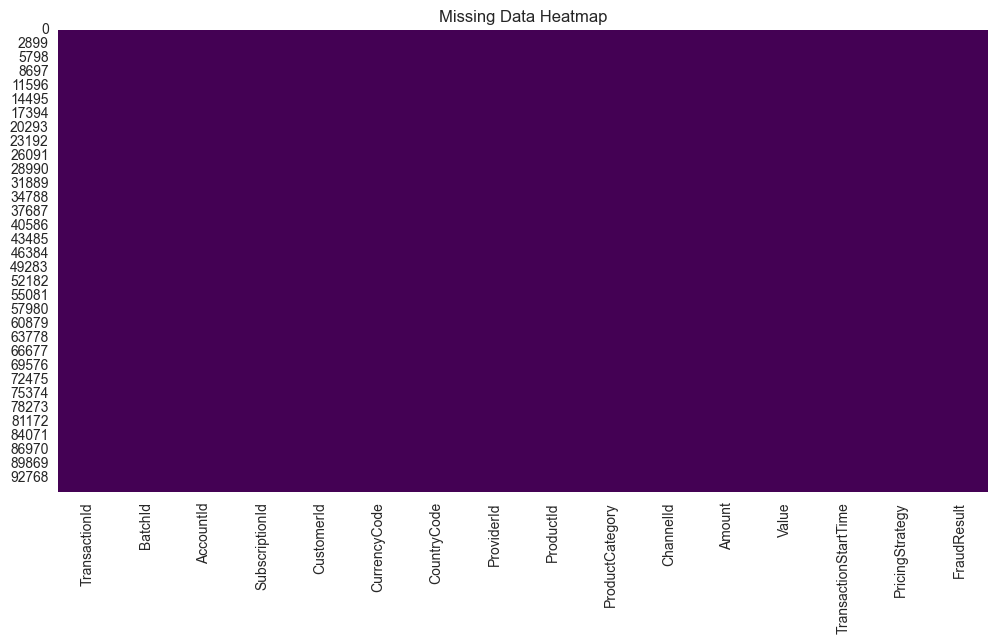

In [6]:
# Calculate percentage of missing values per column
missing_info = df.isnull().sum().sort_values(ascending=False)
missing_info = missing_info[missing_info > 0]
print("--- Columns with Missing Values ---")
print(missing_info)

# Optional: Visualize missing data using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

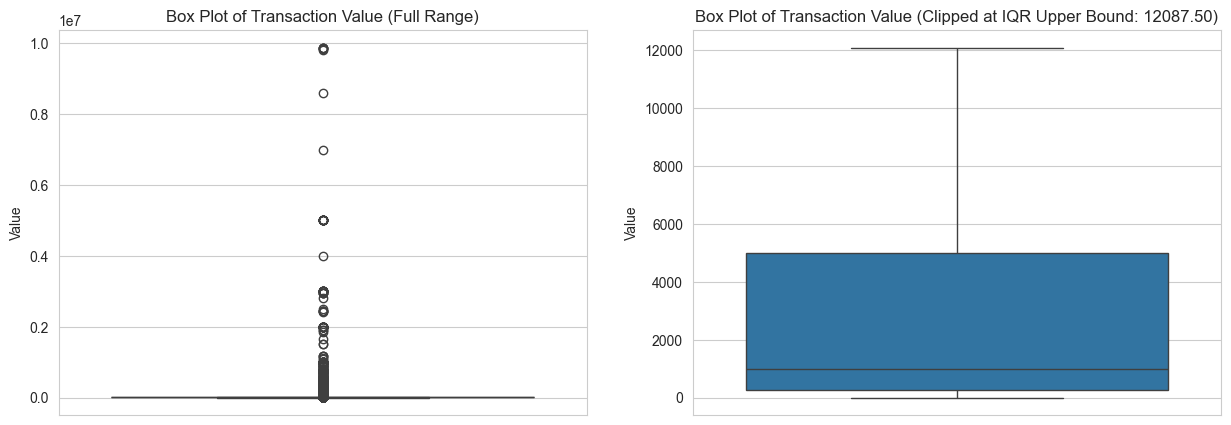

In [7]:
# Focus on the 'Value' column
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Value'])
plt.title('Box Plot of Transaction Value (Full Range)')

# Often, outliers skew the visualization heavily, so visualize on a smaller percentile range
Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Value'].clip(upper=upper_bound)) # Clip for visualization clarity
plt.title(f'Box Plot of Transaction Value (Clipped at IQR Upper Bound: {upper_bound:.2f})')
plt.show()

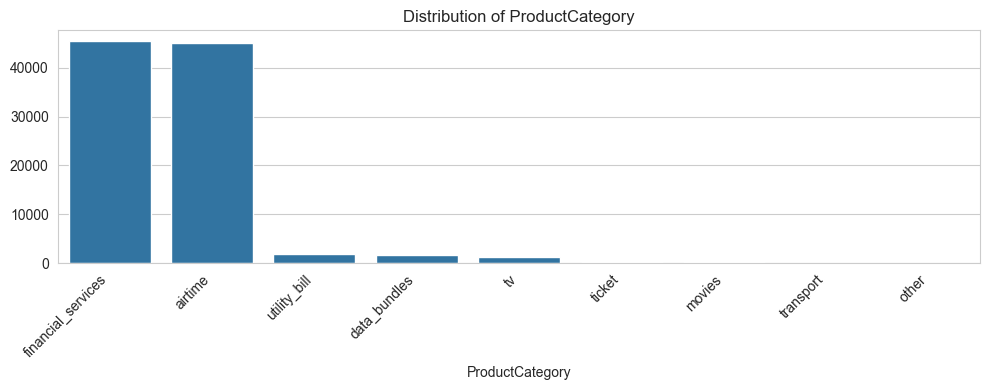

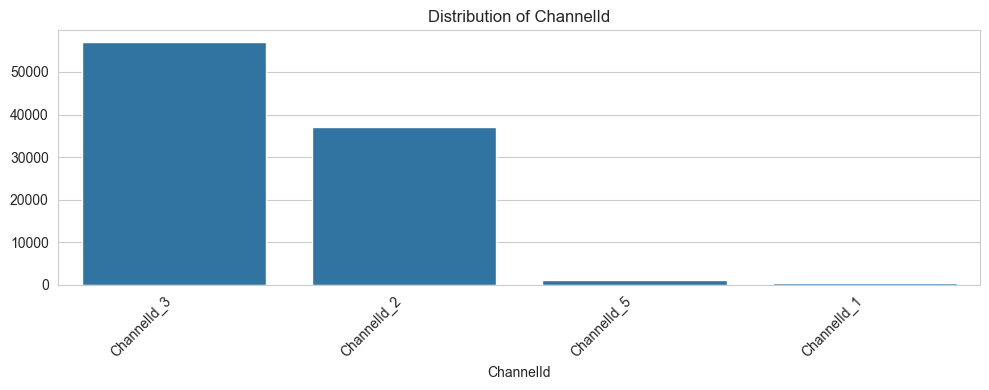

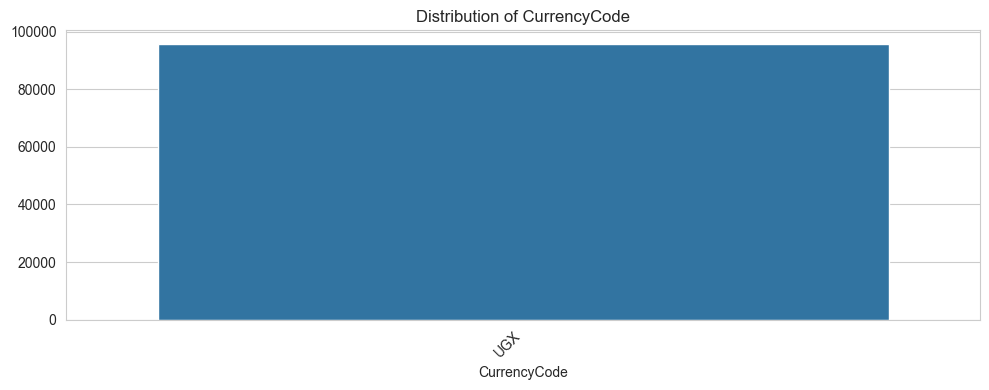

In [8]:
# Example for two key categorical features
categorical_cols = ['ProductCategory', 'ChannelId', 'CurrencyCode']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    # Plot top N categories for clarity, or all if feasible
    top_n = df[col].value_counts().nlargest(10)
    sns.barplot(x=top_n.index, y=top_n.values)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

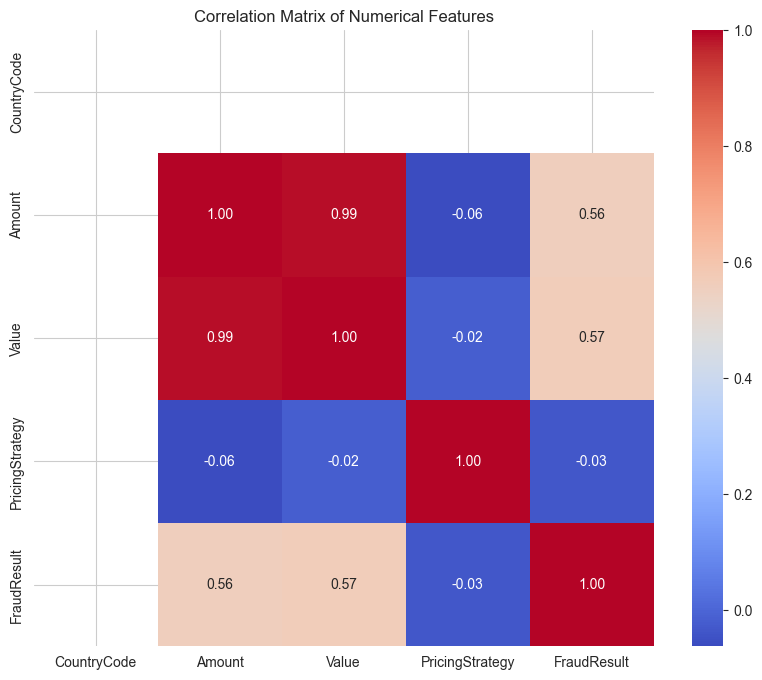

In [9]:
# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Insight check: Note the correlation between 'Amount' and 'Value'

In [10]:
# Convert the transaction time to datetime objects
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract key time features (as per Task 3 instruction)
df['transaction_hour'] = df['TransactionStartTime'].dt.hour
df['transaction_day_of_week'] = df['TransactionStartTime'].dt.day_name()
df['transaction_month'] = df['TransactionStartTime'].dt.month

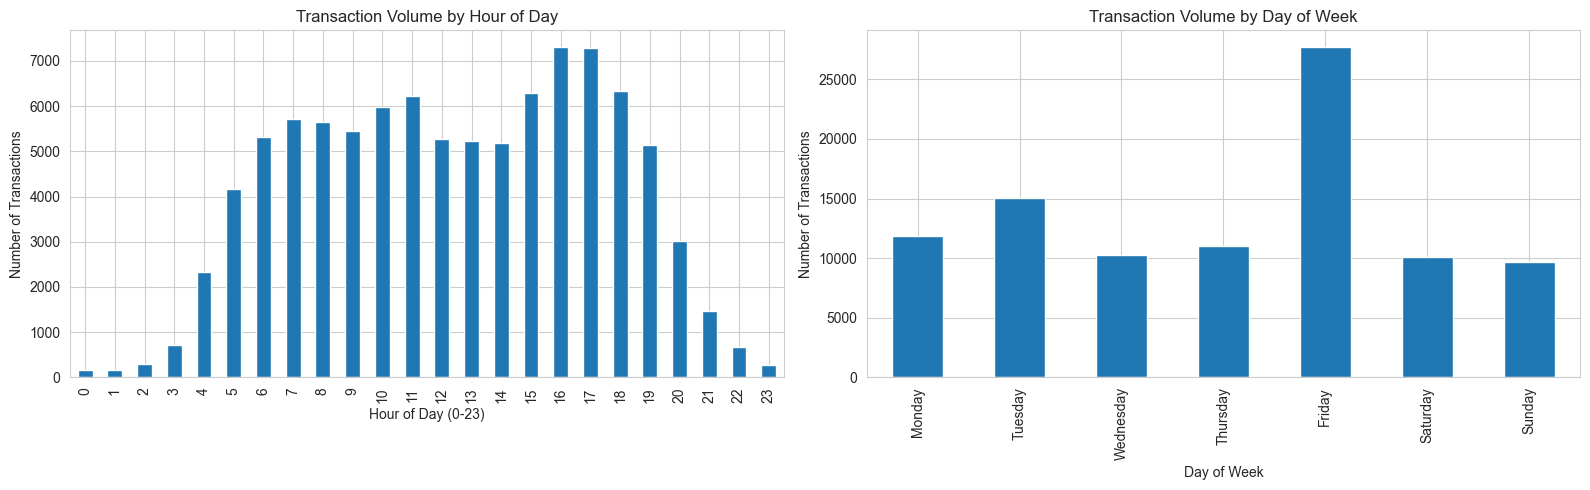

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Transactions by Hour of Day
df.groupby('transaction_hour').size().plot(kind='bar', ax=axes[0])
axes[0].set_title('Transaction Volume by Hour of Day')
axes[0].set_xlabel('Hour of Day (0-23)')
axes[0].set_ylabel('Number of Transactions')

# Transactions by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['transaction_day_of_week'].value_counts().reindex(day_order).plot(kind='bar', ax=axes[1])
axes[1].set_title('Transaction Volume by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

--- Debit/Credit Counts ---
TransactionType
Debit (Customer Spent)        57473
Credit (Customer Received)    38189
Name: count, dtype: int64

--- Total Value by Debit/Credit Type ---


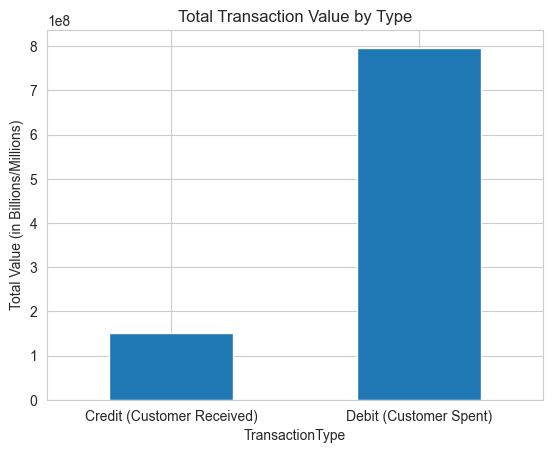

In [12]:
# Create a flag for debit vs. credit
df['TransactionType'] = np.where(df['Amount'] > 0, 'Debit (Customer Spent)', 'Credit (Customer Received)')

# Total count and value by type
print("--- Debit/Credit Counts ---")
print(df['TransactionType'].value_counts())

print("\n--- Total Value by Debit/Credit Type ---")
df.groupby('TransactionType')['Value'].sum().plot(kind='bar')
plt.title('Total Transaction Value by Type')
plt.ylabel('Total Value (in Billions/Millions)')
plt.xticks(rotation=0)
plt.show()

In [13]:
# Check relationship between AccountId and CustomerId
id_map = df.groupby('CustomerId')['AccountId'].nunique()
print("--- Unique AccountIds per CustomerId ---")
print(id_map.value_counts())

# Check relationship between TransactionId and BatchId
print("\n--- Max Transactions per BatchId ---")
print(df['BatchId'].value_counts().max())



--- Unique AccountIds per CustomerId ---
AccountId
3    1722
1    1101
2     861
4      57
5       1
Name: count, dtype: int64

--- Max Transactions per BatchId ---
28


# Key Insights for the data based on the above eda
1.There is no missing data .which have great implication on the quality of the data
2.fraud rate at customer-level is far higher: 1 317 unique CustomerIds appear in at least one fraud transaction → ~2.8 % of customers have already experienced a payment failure.
3.Transaction volume exhibits clear weekly and daily patterns. The volume peaks significantly on Friday , and daily transactions are concentrated in the afternoon/evening (Hours 15-19).
4.The Amount and Value fields are near-perfectly correlated (0.99) , but the difference confirms a mix of transactions: 57,473 are Debits (Customer Spent, positive Amount) and 38,189 are Credits (Customer Received, negative Amount)
5.The ProductCategory and ChannelId distributions are highly imbalanced. Two categories (financial_services and airtime) overwhelmingly dominate the ProductCategory counts.
